## Imports

In [50]:
# Importando bibliotecas necessárias
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from numpy.polynomial.polynomial import Polynomial

### Testes

In [273]:
def treatment_racer(df, fields= ['NUMBER',' DRIVER_NUMBER',' LAP_NUMBER', ' LAP_TIME', 'DRIVER_NAME']):
    for i in df:
        if i not in fields:
            df = df.drop(i, axis=1)
    return df

def group_driver_data(base_path="bancos-de-dados") -> dict:
    """
    Agrupa os dados dos corredores por temporada e corrida, mantendo apenas as colunas relevantes.

    Parâmetros:
    - base_path (str): O caminho base onde os arquivos de dados dos corredores estão localizados.

    Retorna:
    - Um dicionário contendo os dados agrupados por temporada e corrida, representados como DataFrames.
    """
    driver_data_dict = {}
    for season in range(1, 11):  # Considerando temporadas de 1 a 10
        season_path = os.path.join(base_path, f"season{season}")
        race_data_dict = {}
        
        for race in range(1, 21):
            race_number = str(race).zfill(2) if race < 10 else str(race)
            race_path = os.path.join(season_path, f"season{season}Race{race_number}.csv")
            
            if os.path.exists(race_path):
                try:
                    race_df = pd.read_csv(race_path, encoding='utf-8', delimiter=';')
                except UnicodeDecodeError:
                    race_df = pd.read_csv(race_path, encoding='latin1', delimiter=';')
                
                
                race_df = treatment_racer(race_df)
                race_data_dict[race_number] = race_df
                
                
        
        if race_data_dict:
            driver_data_dict[f"season{season}"] = race_data_dict
    
    return driver_data_dict

seasons = group_driver_data()

In [284]:
for season in seasons:
    for race in seasons[season]:
        for column in seasons[season][race]:
            for data in seasons[season][race][column]:
                print(f'{column}: {data}')
                break
        break
    break

NUMBER: 10
 DRIVER_NUMBER: 0
 LAP_NUMBER: 1
 LAP_TIME: 39:30.203
DRIVER_NAME: Jarno Trulli


## Funções

In [285]:
def generate_dataframes(base_path="bancos-de-dados", column_names=["AIR_TEMP", "TRACK_TEMP", "HUMIDITY", "PRESSURE"])->dict:
    """
    Gera dataframes a partir de arquivos CSV contendo dados climáticos.

    Parâmetros:
    - base_path (str): O caminho base onde os arquivos CSV estão localizados.

    Retorna:
    - Um dicionário contendo dataframes para cada temporada.
    """
    # Agrupamento das temporadas em listas. Temporadas 1, 2 e 7 não possuem dados ambientes
    season_folders = [f for f in os.listdir(base_path) if f not in ['season1', 'season2', 'season7']]
    
    season_data_dict = {}
    for season in season_folders:
        season_path = os.path.join(base_path, season)
        
        # Armazenando apenas os arquivos de dados climaticos
        weather_files = [f for f in os.listdir(season_path) if "weather" in f.lower()]
        
        # Armazenando os arquivos de cada corrida por temporada
        season_data = []
        for file in weather_files:
            file_path = os.path.join(season_path, file)
            df = pd.read_csv(file_path, sep=';')
            season_data.append(df)
        
        #Adicionando os arquivos à respeciva temporada
        season_data_dict[season] = season_data
    
    # Tratando as colunas referentes ao vento, pois não serão utilizadas
    for season, dfs in season_data_dict.items():
        season_data_dict[season] = [df.drop(columns=["WIND_SPEED", "WIND_DIRECTION"], errors='ignore') for df in dfs]
    
    # Tratando dados com formatos incorretos
    for season, dfs in season_data_dict.items():
        for df in dfs:
            for column in column_names:
                if df[column].dtype == object:
                    df[column] = df[column].str.replace(',', '.').astype(float)
    
    return season_data_dict

def calculate_averages_races(season_data_dict, column_names=["AIR_TEMP", "TRACK_TEMP", "HUMIDITY", "PRESSURE"])->dict:
    """
    Calcula as médias de temperaturas, umidade e pressão, por corrida, em cada temporada.

    Parâmetros:
    - season_data_dict (dict): Um dicionário contendo dataframes para cada temporada.
    - column_names (list): Uma lista contendo os nomes das colunas a serem consideradas para o cálculo das médias.

    Retorna:
    - Um dicionário contendo as média, por corrida, por temporada.
    """
    # Agrupamento por temporada
    averages_dict = {}
    for season, dfs in season_data_dict.items():
        
        # Agrupamento por corrida
        season_averages = []
        for df in dfs:
            averages = {col: df[col].mean() for col in column_names if col in df.columns}
            season_averages.append(averages)
        averages_dict[season] = season_averages
    
    return averages_dict

def calculate_general_season_averages(season_data_dict)->dict:
    """
    Calcula e agrupa as médias de temperaturas, umidade e pressão, por temporada.

    Parâmetros:
    - season_data_dict (dict): Um dicionário contendo dataframes para cada temporada.

    Retorna:
    - Um dicionário contendo as médiass de cada medida agrupadas por temporada.
    """
    general_averages = {season_data: averages_dict(season_data_dict[season_data]) for season_data in season_data_dict}
    return general_averages

def averages_dict(season_data)->dict:
    """
    Calcula a média geral das colunas de cada temporada.

    Parâmetros:
    - season_data (list): Uma lista contendo os dataframes de uma temporada.

    Retorna:
    - Um dicionário contendo as médias de cada medida para a temporada.
    """
    sum_air_temp = 0
    sum_track_temp = 0
    sum_humidity_temp = 0
    sum_pressure_temp = 0
        
    for data in season_data:
        for coluna in data:
            match coluna:
                case "AIR_TEMP":
                    sum_air_temp += data[coluna]
                case "TRACK_TEMP":
                    sum_track_temp += data[coluna]
                case "HUMIDITY":
                    sum_humidity_temp += data[coluna]
                case "PRESSURE":
                    sum_pressure_temp += data[coluna]
                
    average_air_temp = sum_air_temp / len(season_data)
    average_track_temp = sum_track_temp / len(season_data)
    average_humidity_temp = sum_humidity_temp / len(season_data)
    average_pressure_temp = sum_pressure_temp / len(season_data)
    
    data = {
        'AIR_TEMP': average_air_temp, 
        'TRACK_TEMP': average_track_temp, 
        'HUMIDITY': average_humidity_temp, 
        'PRESSURE': average_pressure_temp
        }
    return data

def template_gra(seasons, values, measure_name, y_label, y_min, y_max) -> None:
    """
    Plota um gráfico de linhas para uma medida climática ao longo das temporadas.

    Parâmetros:
    - seasons (list): Lista de temporadas.
    - values (list): Lista de valores da medida climática.
    - measure_name (str): Nome da medida climática.
    - y_label (str): Rótulo do eixo y.
    - y_min (float): Valor mínimo do eixo y.
    - y_max (float): Valor máximo do eixo y.
    """
    plt.figure(figsize=(6, 3))
    plt.plot(seasons, values, marker='o')
    plt.ylim(y_min, y_max)
    plt.title(f'{measure_name} por Temporada')
    plt.xlabel('Temporada')
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

def graficos_clima(medias_gerais)->None:
    """
    Gera gráficos das médias climáticas ao longo das temporadas.

    Parâmetros:
    - medias_gerais (dict): Um dicionário contendo as médias climáticas por temporada.
    """
    seasons = list(medias_gerais.keys())
    air_temps = [medias_gerais[season]['AIR_TEMP'] for season in seasons]
    track_temps = [medias_gerais[season]['TRACK_TEMP'] for season in seasons]
    humidities = [medias_gerais[season]['HUMIDITY'] for season in seasons]
    pressures = [medias_gerais[season]['PRESSURE'] for season in seasons]

    template_gra(seasons, air_temps, 'Temperatura do Ar', 'Temperatura (°C)', 0, 50)
    template_gra(seasons, track_temps, 'Temperatura da Pista', 'Temperatura (°C)', 0, 50)
    template_gra(seasons, humidities, 'Umidade', 'Umidade (%)', 0, 100)
    template_gra(seasons, pressures, 'Pressão', 'Pressão (hPa)', 900, 1084)

def heatmap_clima(medias_gerais)->None:
    """
    Gera um heatmap das correlações entre as medidas climáticas.

    Parâmetros:
    - medias_gerais (dict): Um dicionário contendo as médias climáticas por temporada.
    """
    df = pd.DataFrame(medias_gerais).T
    corr = df.corr()

    plt.figure(figsize=(6, 3))
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlações entre Medidas Climáticas')
    plt.show()
    
def plot_quadratic_fit(x, y, x_label, y_label, title):
        p = Polynomial.fit(x, y, 2)
        x_new = np.linspace(min(x), max(x), 100)
        y_new = p(x_new)
        
        plt.figure(figsize=(6, 3))
        plt.scatter(x, y, color='blue', label='Data')
        plt.plot(x_new, y_new, color='red', label='Quadratic fit')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

def plot_driver_performance(driver_performance, medias_gerais, driver_name)->None:
    """
    Plota o desempenho de um corredor em relação às estatísticas climáticas.

    Parâmetros:
    - driver_performance (dict): Um dicionário contendo o desempenho do corredor em cada temporada.
    - medias_gerais (dict): Um dicionário contendo as médias climáticas por temporada.
    - driver_name (str): Nome do corredor.
    """
    seasons = list(medias_gerais.keys())
    air_temps = [medias_gerais[season]['AIR_TEMP'] for season in seasons]
    track_temps = [medias_gerais[season]['TRACK_TEMP'] for season in seasons]
    humidities = [medias_gerais[season]['HUMIDITY'] for season in seasons]
    pressures = [medias_gerais[season]['PRESSURE'] for season in seasons]
    
    performance = [driver_performance[season] for season in seasons]

    plot_quadratic_fit(air_temps, performance, 'Temperatura do Ar (°C)', 'Desempenho', f'{driver_name} vs Temperatura do Ar')
    plot_quadratic_fit(track_temps, performance, 'Temperatura da Pista (°C)', 'Desempenho', f'{driver_name} vs Temperatura da Pista')
    plot_quadratic_fit(humidities, performance, 'Umidade (%)', 'Desempenho', f'{driver_name} vs Umidade')
    plot_quadratic_fit(pressures, performance, 'Pressão (hPa)', 'Desempenho', f'{driver_name} vs Pressão')

## Execução

### Base

In [286]:
# Código principal
clima_df_list = generate_dataframes()
medias_clima = calculate_averages_races(clima_df_list)
medias_gerais = calculate_general_season_averages(medias_clima)

# Exemplo de dados de desempenho de corredores (substitua pelos dados reais)
driver_performance = {
    'season3': 100,
    'season4': 80,
    'season5': 50,
    'season6': 30,
    'season8': 60,
    'season9': 40
}

### Gráficos

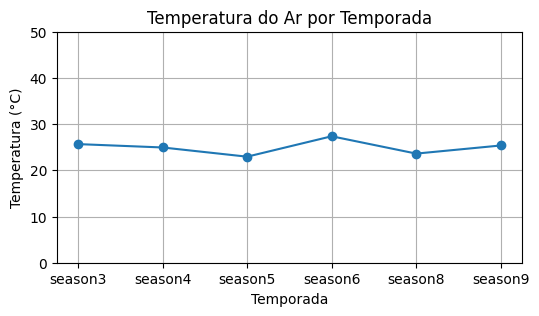

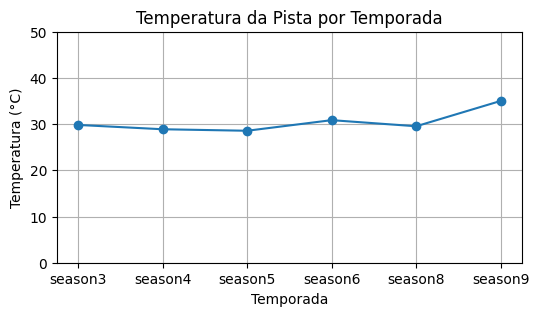

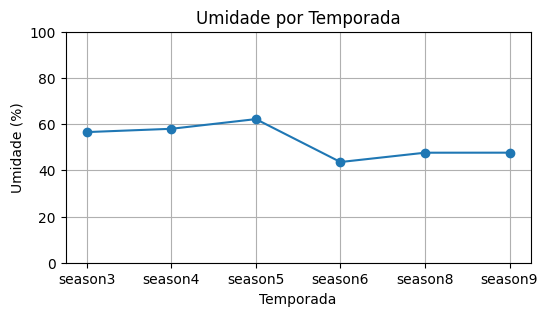

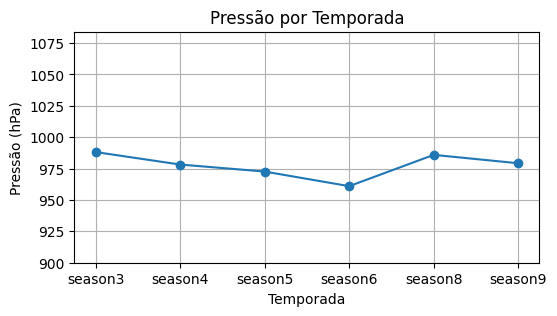

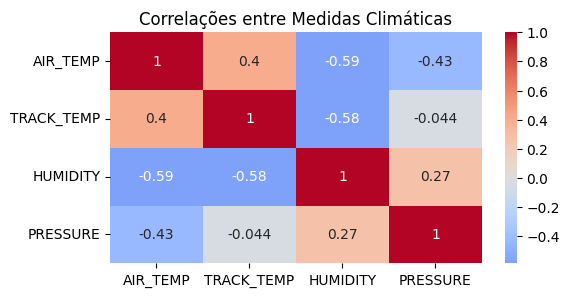

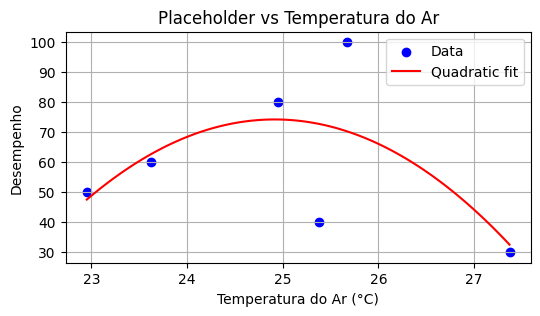

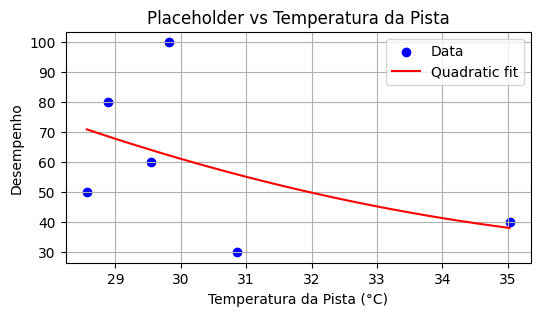

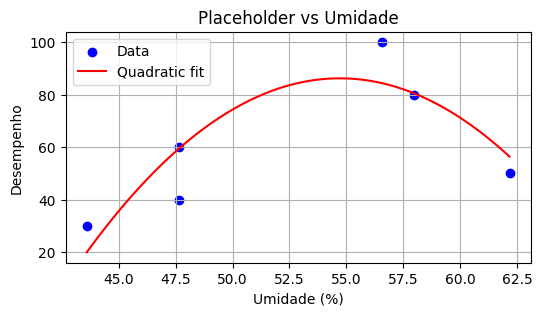

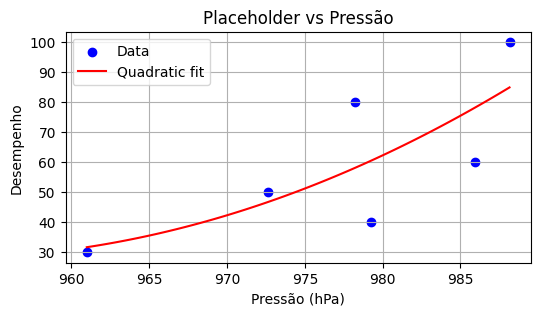

In [287]:
graficos_clima(medias_gerais)
heatmap_clima(medias_gerais)
plot_driver_performance(driver_performance, medias_gerais, 'Placeholder')